# Introduction

Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting (“curse of dimensionality”) and also reduce computational costs.

Ronald A. Fisher formulated the Linear Discriminant in 1936 (The Use of Multiple Measurements in Taxonomic Problems), and it also has some practical uses as classifier. The original Linear discriminant was described for a 2-class problem, and it was then later generalized as “multi-class Linear Discriminant Analysis” or “Multiple Discriminant Analysis” by C. R. Rao in 1948 (The utilization of multiple measurements in problems of biological classification)

The general LDA approach is very similar to a Principal Component Analysis (for more information about the PCA, see the previous article Implementing a Principal Component Analysis (PCA) in Python step by step), but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA).

So, in a nutshell, often the goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace k
(where k≤n−1) while maintaining the class-discriminatory information.
In general, dimensionality reduction does not only help reducing computational costs for a given classification task, but it can also be helpful to avoid overfitting by minimizing the error in parameter estimation (“curse of dimensionality”).

# Principal Component Analysis vs. Linear Discriminant Analysis

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes.

Although it might sound intuitive that LDA is superior to PCA for a multi-class classification task where the class labels are known, this might not always the case.
For example, comparisons between classification accuracies for image recognition after using PCA or LDA show that PCA tends to outperform LDA if the number of samples per class is relatively small (PCA vs. LDA, A.M. Martinez et al., 2001). In practice, it is also not uncommon to use both LDA and PCA in combination: E.g., PCA for dimensionality reduction followed by an LDA.

In [4]:
from IPython.display import Image

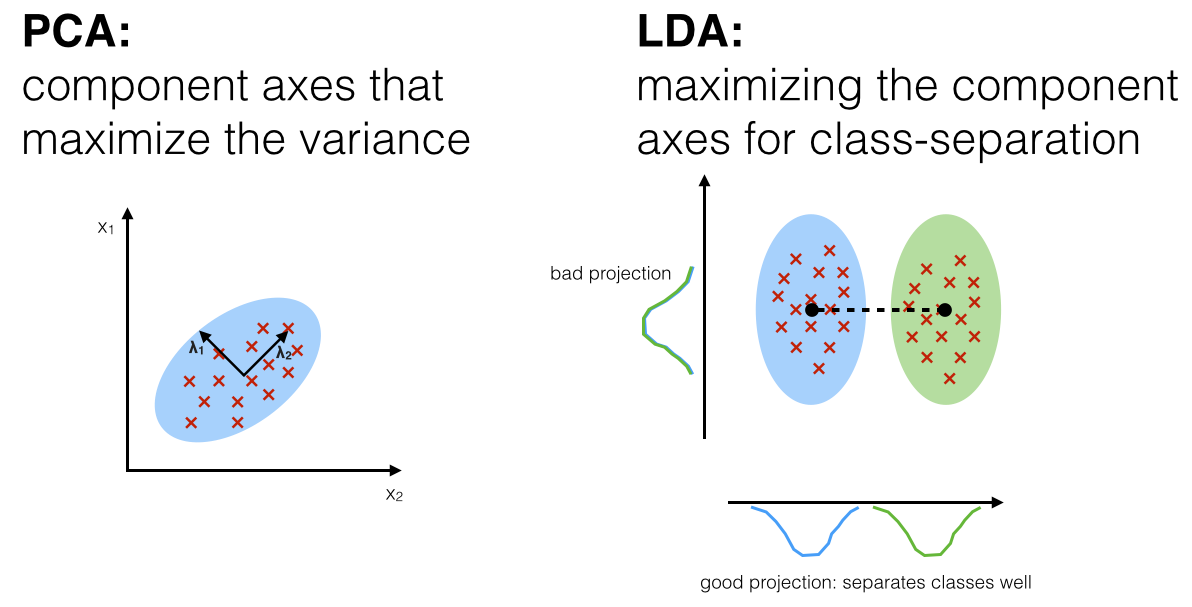

In [5]:
Image(filename='lda_1.png', width=500) 

# What is a “good” feature subspace?

Let’s assume that our goal is to reduce the dimensions of a d
-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k<d). So, how do we know what size we should choose for k (k= the number of dimensions of the new feature subspace), and how do we know if we have a feature space that represents our data “well”?

Later, we will compute eigenvectors (the components) from our data set and collect them in a so-called scatter-matrices (i.e., the in-between-class scatter matrix and within-class scatter matrix).

Each of these eigenvectors is associated with an eigenvalue, which tells us about the “length” or “magnitude” of the eigenvectors.

If we would observe that all eigenvalues have a similar magnitude, then this may be a good indicator that our data is already projected on a “good” feature space.

And in the other scenario, if some of the eigenvalues are much much larger than others, we might be interested in keeping only those eigenvectors with the highest eigenvalues, since they contain more information about our data distribution. Vice versa, eigenvalues that are close to 0 are less informative and we might consider dropping those for constructing the new feature subspace.

# Summarizing the LDA approach in 5 steps



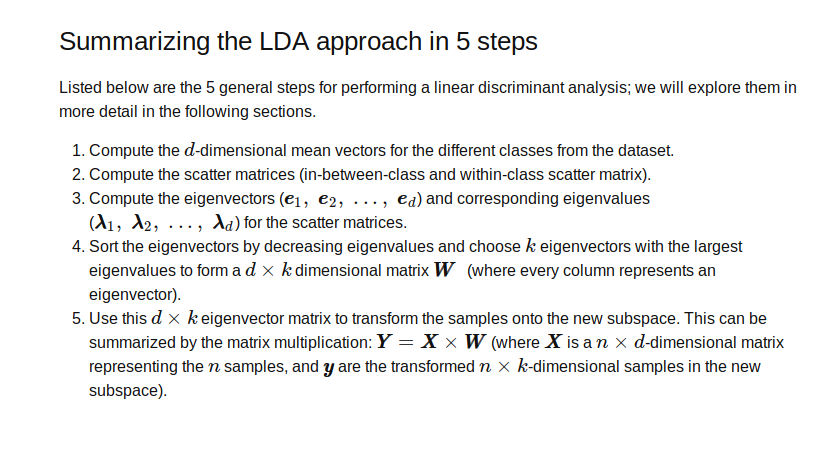

In [7]:
Image(filename='lda_2.png', width=700) 

# Preparing the sample data set

The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:

    Iris-setosa (n=50)
    Iris-versicolor (n=50)
    Iris-virginica (n=50)

The four features of the Iris dataset:

    sepal length in cm
    sepal width in cm
    petal length in cm
    petal width in cm


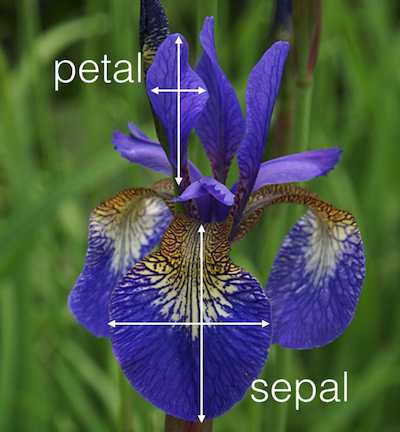

In [8]:
Image(filename='iris_petal_sepal.png', width=300) 

In [1]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}


In [2]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )

df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.head()


,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


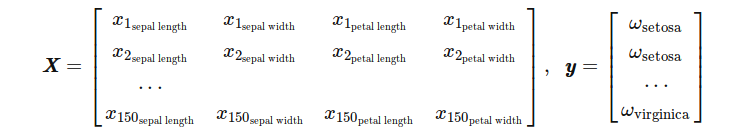

In [6]:
Image(filename='lda3.png', width=700) 

Since it is more convenient to work with numerical values, we will use the LabelEncode from the scikit-learn library to convert the class labels into numbers: 1, 2, and 3.

In [8]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,0:4].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}


In [9]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

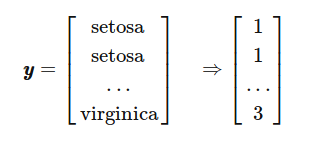

In [10]:
Image(filename='lda4.png', width=400) 

# Histograms and feature selection

Just to get a rough idea how the samples of our three classes ω1
, ω2 and ω3 are distributed, let us visualize the distributions of the four different features in 1-dimensional histograms.

/home/govinth/anaconda3/envs/deeplearn/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


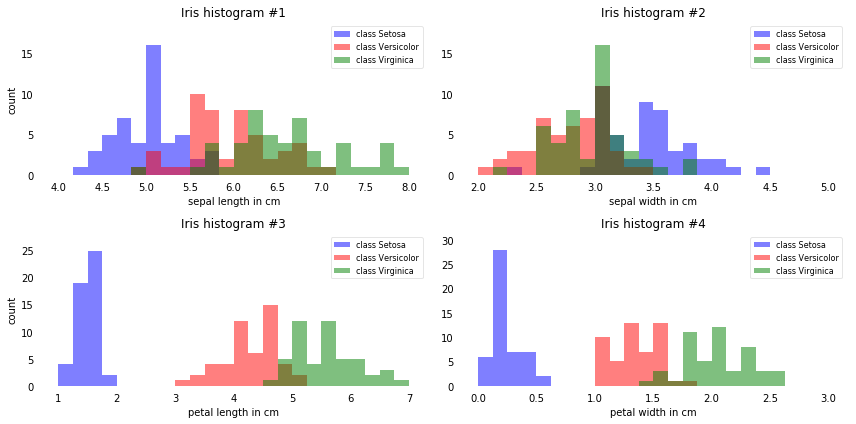

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()


From just looking at these simple graphical representations of the features, we can already tell that the petal lengths and widths are likely better suited as potential features two separate between the three flower classes. In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique. For low-dimensional datasets like Iris, a glance at those histograms would already be very informative. Another simple, but very useful technique would be to use feature selection algorithms; in case you are interested, I have a more detailed description on sequential feature selection algorithms here, and scikit-learn also implements a nice selection of alternative approaches. For a high-level summary of the different approaches, I’ve written a short post on “What is the difference between filter, wrapper, and embedded methods for feature selection?”.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f72fc1eb550>,
      dtype=object)

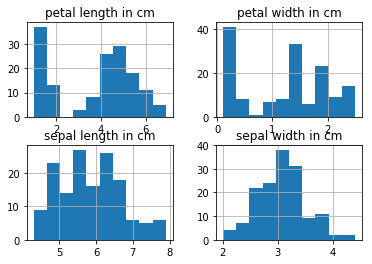

In [12]:
df.hist()

# Normality assumptions

It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data:

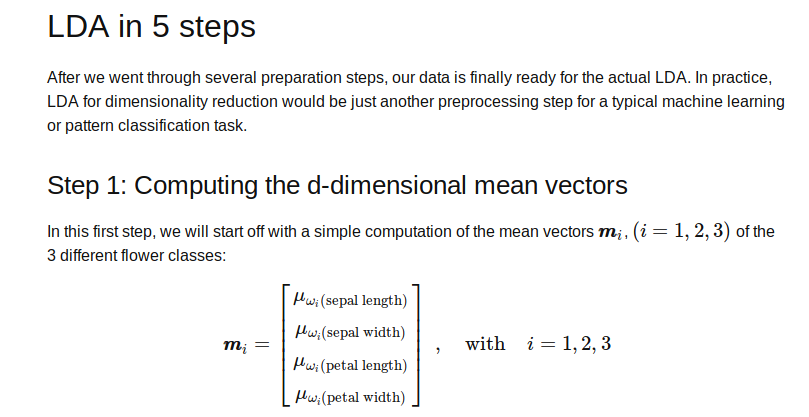

In [10]:
Image(filename='lda5.png', width=600) 

In [13]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))


Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



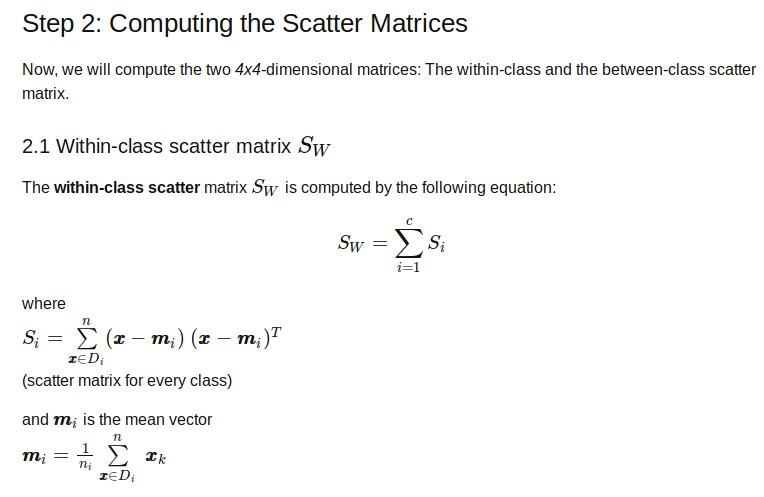

In [20]:
Image(filename='lda6.png', width=600)

In [14]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)


within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


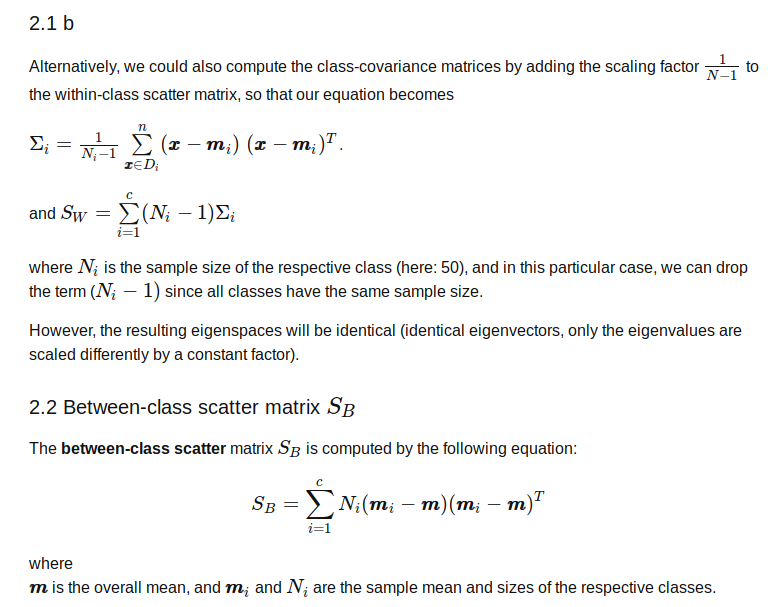

In [22]:
Image(filename='lda7.png', width=600)

In [15]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)


between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


# Step 3: Solving the generalized eigenvalue problem for the matrix S−1WSB

Next, we will solve the generalized eigenvalue problem for the matrix S−1WSB
to obtain the linear discriminants.

In [35]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))



Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8379]
 [ 0.1696]
 [ 0.1229]
 [ 0.5041]]
Eigenvalue 3: -4.13e-15

Eigenvector 4: 
[[ 0.2   ]
 [-0.3949]
 [-0.4567]
 [ 0.7717]]
Eigenvalue 4: 1.20e-14


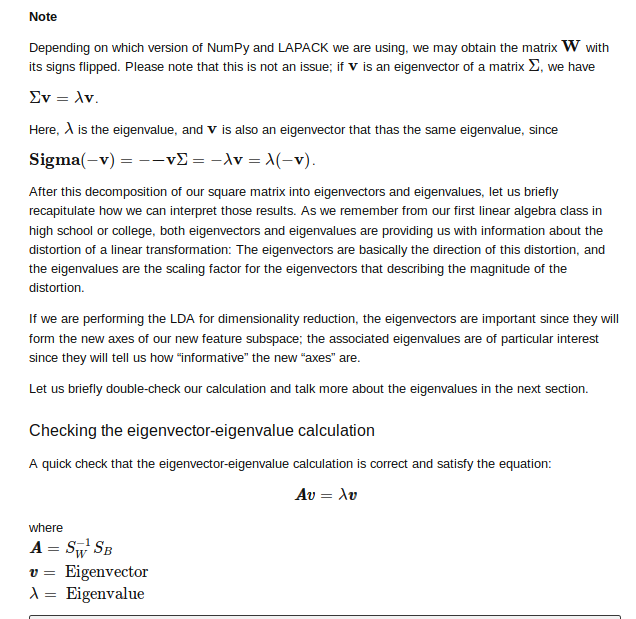

In [36]:
Image(filename='lda8.png', width=600)

In [37]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')


ok


# Step 4: Selecting linear discriminants for the new feature subspace
4.1. Sorting the eigenvectors by decreasing eigenvalues

Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace).

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top k
eigenvectors.

In [38]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])


Eigenvalues in decreasing order:

32.27195779972981
0.27756686384004264
1.1953730364935478e-14
4.1311796919088535e-15


# Note

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0. The reason why these are close to 0 is not that they are not informative but it’s due to floating-point imprecision. In fact, these two last eigenvalues should be exactly zero: In LDA, the number of linear discriminants is at most c−1
where c is the number of class labels, since the in-between scatter matrix SB is the sum of c

matrices with rank 1 or less. Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

Now, let’s express the “explained variance” as percentage:

In [39]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


The first eigenpair is by far the most informative one, and we won’t loose much information if we would form a 1D-feature spaced based on this eigenpair.

# 4.2. Choosing k eigenvectors with the largest eigenvalues

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d
-dimensional eigenvector matrix W (here 4×2: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [40]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)


Matrix W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


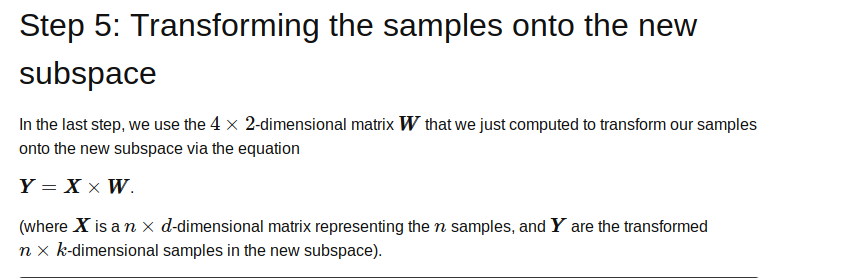

In [41]:
Image(filename='lda9.png', width=600)

In [42]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."


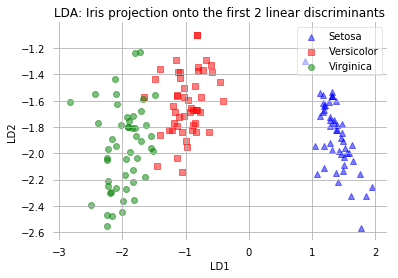

In [43]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()


The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant “LD1” separates the classes quite nicely. However, the second discriminant, “LD2”, does not add much valuable information, which we’ve already concluded when we looked at the ranked eigenvalues is step 4.

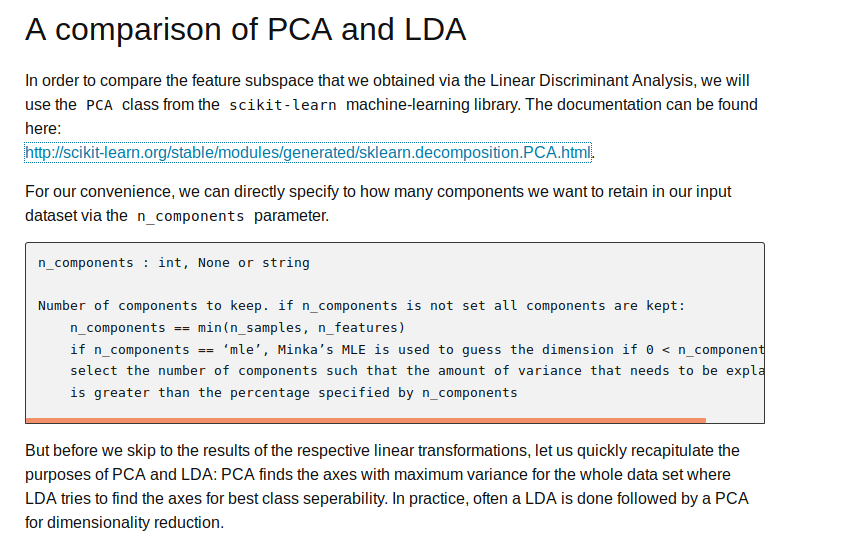

In [45]:
Image(filename='lda10.png', width=700)

In [46]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()


/home/govinth/anaconda3/envs/deeplearn/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


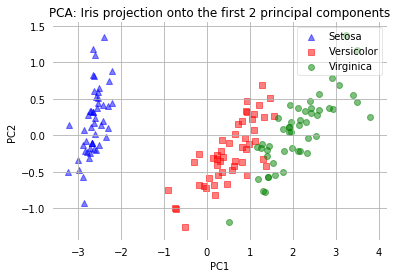

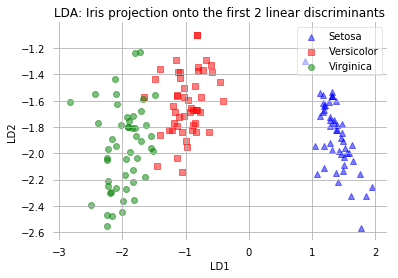

In [47]:
plot_pca()
plot_step_lda()


The two plots above nicely confirm what we have discussed before: Where the PCA accounts for the most variance in the whole dataset, the LDA gives us the axes that account for the most variance between the individual classes.

# LDA via scikit-learn

Now, after we have seen how an Linear Discriminant Analysis works using a step-by-step approach, there is also a more convenient way to achive the same via the LDA class implemented in the scikit-learn machine learning library.

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)


In [49]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()


/home/govinth/anaconda3/envs/deeplearn/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


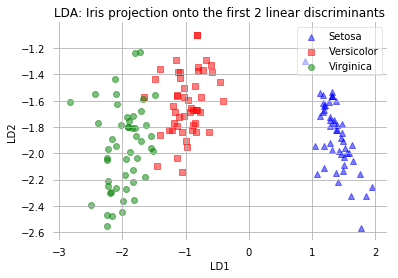

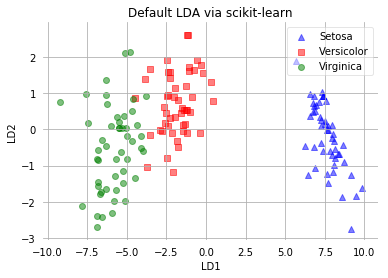

In [50]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')


# A Note About Standardization

To follow up on a question that I received recently, I wanted to clarify that feature scaling such as [standardization] does not change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, the important part is that the eigenvalues will be exactly the same as well as the final projects – the only difference you’ll notice is the scaling of the component axes. This can be shown mathematically (I will insert the formulaes some time in future), and below is a practical, visual example for demonstration.

In [51]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df[4] = df[4].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
df.tail()


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


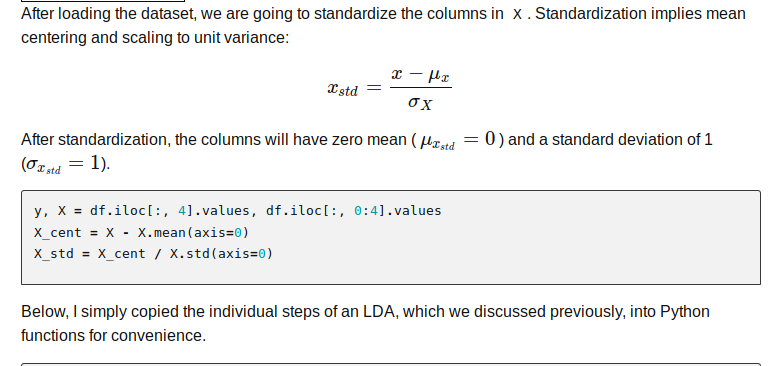

In [52]:
Image(filename='lda11.png', width=700)

In [53]:
y, X = df.iloc[:, 4].values, df.iloc[:, 0:4].values
X_cent = X - X.mean(axis=0)
X_std = X_cent / X.std(axis=0)


In [54]:
import numpy as np

def comp_mean_vectors(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y==cl], axis=0))
    return mean_vectors

def scatter_within(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)
    S_W = np.zeros((n_features, n_features))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((n_features, n_features))                 
        for row in X[y == cl]:
            row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                           
    return S_W

def scatter_between(X, y):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)    
    S_B = np.zeros((n_features, n_features))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        overall_mean = overall_mean.reshape(n_features, 1)
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

def get_components(eig_vals, eig_vecs, n_comp=2):
    n_features = X.shape[1]
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.hstack([eig_pairs[i][1].reshape(4, 1) for i in range(0, n_comp)])
    return W


First, we are going to print the eigenvalues, eigenvectors, transformation matrix of the un-scaled data:

In [55]:
S_W, S_B = scatter_within(X, y), scatter_between(X, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W)


EigVals: [ 2.0905e+01+0.000e+00j  1.4283e-01+0.000e+00j -6.9935e-16+8.447e-16j
 -6.9935e-16-8.447e-16j]

EigVecs: [[ 0.2067+0.j      0.0018+0.j     -0.281 +0.1937j -0.281 -0.1937j]
 [ 0.4159+0.j     -0.5626+0.j     -0.2173-0.0855j -0.2173+0.0855j]
 [-0.5616+0.j      0.2232+0.j     -0.2894-0.0843j -0.2894+0.0843j]
 [-0.6848+0.j     -0.796 +0.j      0.8592+0.j      0.8592-0.j    ]]

W: [[ 0.2067+0.j  0.0018+0.j]
 [ 0.4159+0.j -0.5626+0.j]
 [-0.5616+0.j  0.2232+0.j]
 [-0.6848+0.j -0.796 +0.j]]


/home/govinth/anaconda3/envs/deeplearn/lib/python3.5/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


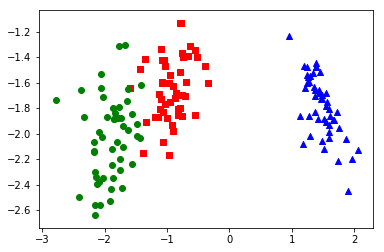

In [56]:
X_lda = X.dot(W)
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_lda[y==label, 0], X_lda[y==label, 1],
                color=color, marker=marker)


Next, we are repeating this process for the standarized flower dataset:

In [57]:
S_W, S_B = scatter_within(X_std, y), scatter_between(X_std, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W_std = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W_std)


EigVals: [ 2.0905e+01  1.4283e-01 -5.0076e-16  2.0494e-16]

EigVecs: [[-0.1492 -0.0019  0.7292 -0.7426]
 [-0.1572  0.3193 -0.1661  0.021 ]
 [ 0.8635 -0.5155 -0.6637 -0.0511]
 [ 0.4554  0.7952 -0.0109  0.6675]]

W: [[-0.1492 -0.0019]
 [-0.1572  0.3193]
 [ 0.8635 -0.5155]
 [ 0.4554  0.7952]]


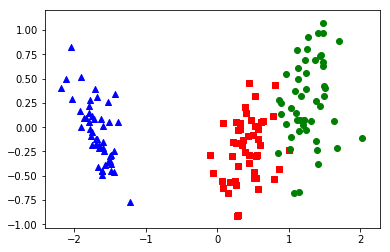

In [58]:
X_std_lda = X_std.dot(W_std)
X_std_lda[:, 1] = X_std_lda[:, 1]
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_std_lda[y==label, 0], X_std_lda[y==label, 1],
                color=color, marker=marker)


As we can see, the eigenvalues are excactly the same whether we scaled our data or not (note that since W has a rank of 2, the two lowest eigenvalues in this 4-dimensional dataset should effectively be 0). Furthermore, we see that the projections look identical except for the different scaling of the component axes and that it is mirrored in this case.